__Universidade Federal do Pará  
  Disciplina: Tópicos Especiais em Inteligência Artificial  
  Docente: Claudomiro Sales  
  Discente: Hiago Cavalcante Prata  
  Matrícula: 201406840049__

---

### Atividade 03: Randomwalk X Algoritmo Genético

[PARTE 1: Introdução](#PARTE-1:-Introdução)  
&nbsp;&nbsp;[1.1. Contexto](#1.1.-Contexto)  
&nbsp;&nbsp;[1.2. Implementação](#1.2.-Implementação)    

[PARTE 2: Randomwalk](#PARTE-2:-Randomwalk)  
&nbsp;&nbsp;[2.1. Introdução](#2.1.-Introdução)  
&nbsp;&nbsp;[2.2. Testes](#2.2.-Testes)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1. Cenário 1](#2.2.1.-Cenário-1)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2. Cenário 2](#2.2.2.-Cenário-2)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2. Cenário 3](#2.2.3.-Cenário-3)  
&nbsp;&nbsp;[3.3. Resultados](#3.3.-Resultados)  

[PARTE 3: Algoritmo Genético](#PARTE-3:-Algoritmo-Genético)  
&nbsp;&nbsp;[3.1. Introdução](#3.1.-Introdução)  
&nbsp;&nbsp;[3.2. Seleção de parâmetros](#3.2.-Seleção-de-parâmetros)  
&nbsp;&nbsp;[3.3. Testes](#3.3.-Testes)  
&nbsp;&nbsp;&nbsp;&nbsp;[3.3.1. Cenário 1](#3.3.1.-Cenário-1)  
&nbsp;&nbsp;&nbsp;&nbsp;[3.3.2. Cenário 2](#3.3.2.-Cenário-2)  
&nbsp;&nbsp;&nbsp;&nbsp;[3.3.3. Cenário 3](#3.3.3.-Cenário-3)  
&nbsp;&nbsp;[3.4. Resultados](#3.4.-Resultados)  

[PARTE 4: Avaliação de resultados](#PARTE-4:-Avaliação-de-resultados)  
&nbsp;&nbsp;[4.3. Baseline](#4.3.-Baseline)  
&nbsp;&nbsp;[4.4. Hipóteses](#4.4.-Hipóteses)  
&nbsp;&nbsp;[4.5. Resultados](#4.5.-Resultados)  
&nbsp;&nbsp;[4.6. Considerações Finais](#4.6.-Considerações-Finais)  

---

# PARTE 1: Introdução

## 1.1. Contexto

Algumas classes de problemas não chegam a ser suficientemente complexas para que um algoritmo específico seja desenvolvido para solucioná-lo. Para isso, existem métodos heurísticos que podem ser aplicados na resolução de tal problema. E alguns desses métodos são baseados no comportamento de processos estocásticos (_Randomwalk_), onde não se faz necessário a utilização de mecanismos de controle complexos para que se alcance a solução.

Tendo isso em vista, um método heurístico foi criado para tentar resolver o problema proposto.

Abaixo segue a implementação:

## 1.2. Implementação

In [2]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

import time
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy


def round_up(num):
    """
    Returns the multiple of ten next to `num`.
    """
    if num % 10:
        return (10 - num % 10) + num
    else:
        return num

class Chromosome:
    """
    Implements basic structure for
    storing and operating on algorithm data.
    """
    def __init__(self, size=0, alphabet=[]):
        if not size:
            self.genes = np.ndarray(size)
        else:
            np.random.seed()
            self.genes = np.random.choice(alphabet, size)

        self.fitness = 0

    def __str__(self):
        return "".join(list(map(str, self.genes)))

    def calculate_fitness(self, target):
        """
        Calculates fitness of the individual
        given a target.
        """
        hits = 0
        for i, j in zip(self.genes, target):
            if i == j:
                hits += 1
        self.fitness = (hits * 100) / len(target)


class Population:
    """
    Implements basic operations on a set
    of Chromosome objects.
    """

    def __init__(self, alphabet, psize, csize):
        """
        :param alphabet: Symbols used to generate the chromosomes.
        :param psize: Population size.
        :param csize: Chromosome size.
        """
        self.alphabet = alphabet
        self.psize = psize
        self.csize = csize
        self.population = self._gen_pop(psize, csize, alphabet)

    def __str__(self):
        return "\n".join(map(str, self.population))

    def update(self, target):
        """
        Updates the fitness value for every
        individual in the population based on
        the given target.
        """
        for c in self.population:
            c.calculate_fitness(self.target)

    def get_fitness(self):
        """
        Returns the fitness value for every
        individual in the population.
        """
        return [c.fitness for c in self.population]

    def sort(self):
        """
        Sorts the elements of the population
        based on its fitness values.
        """
        self.population = sorted(self.population, key=lambda chromosome: chromosome.fitness)

    def renew(self):
        """
        Eliminates the half of the population
        with the worst fitness values, replacing
        them with a list of new randomly generated
        individuals.
        """
        index = int(len(self.population) / 2)
        self.population = self._gen_pop(index, self.csize, self.alphabet) \
                          + self.population[index:]

    def _gen_pop(self, psize, csize, alphabet):
        """
        Generates a new list of individuals randomly.

        :param psize: Size of the population to be generated.
        :param csize: Size of the Chromosome to be generated.
        :param alphabet: Set of symbols used to generate the population individuals.
        :return: A list of randomly generated individuals.
        """
        return [Chromosome(csize, alphabet) for _ in range(psize)]


class Randomwalk(Population):
    """
    Implements the steps of a Randomwalk
    algorithm based on the methods of the
    Population class.
    """
    def __init__(self, alphabet, target, psize, gcounter, tcounter=30):
        """
        :param alphabet: Symbols used to generate the population individuals.
        :param target: The target to be achieved by the algorithm.
        :param psize: Population size.
        :param gcounter: Max generations without change in best fitness permited.
        :param tcounter: Number of times the algorithm is executed.
        """
        self.alphabet = alphabet
        self.target = target
        self.csize = len(self.target)
        self.psize = psize
        self.gcounter = gcounter
        self.tcounter = tcounter

    def run(self, verbose=False):
        """
        Routine that combines the methods of the
        base class (Population) to perform the algorithm.

        :param verbose: If **True**, logs info during the execution of the algorithm.
        """

        # Initiate a list to receive the best fitness values
        # achieved per execution.
        self.best_scores = []

        # Initiate a list to receive the number of generations
        # spent per execution.
        self.generations = []

        if verbose:
            then = time.time()

            print("{!s} started...".format(type(self).__name__))
            print("Target: {!s}".format("".join(map(str, self.target))))
            print("Population size: {!s}".format(self.psize))
            print("Total executions: {!s}".format(self.tcounter))
            print("Max generations without change: {!s}\n".format(self.gcounter))

        # Runs the algorithm tcounter times.
        for i in range(self.tcounter):

            # Initiates the population and updates its fitness values
            # based on a given target.
            self.population = self._gen_pop(self.psize, self.csize, self.alphabet)
            self.update(self.target)

            # Initiates a list to receive the best fitness values
            # achieved per generation.
            scores = []

            j = 0  # Holds the value of the best fitness per generation.
            k = 1  # Holds the current generation.
            g = 0  # Holds the number of generations with no changes to the best fitness.

            if verbose:
                print("\nExecution {!s} started...\n".format(i + 1))

            while g < self.gcounter:

                self.sort()
                self.renew()
                self.update(self.target)
                self.sort()

                j = self.get_fitness()[-1]
                scores.append(j)

                # Only compares the last two elements of
                # score, if at least 2 generations had
                # been executed.
                if k >= 2:
                    if scores[-1] == scores[-2]:
                        g += 1
                    else:
                        g = 0

                if verbose:
                    print("\tGeneration {!s}".format(k))
                    print("\tBest individual: {!s}".format(self.population[-1]))
                    print("\tBest score: {!s}%\n".format(j))

                if j == 100:
                    if verbose:
                        print("\tTarget found!\n")
                    k += 1
                    break

                k += 1

            self.best_scores.append(scores)
            self.generations.append(k - 1)

            if verbose:
                print("Execution {0!s} ended in {1!s} generations".format(i + 1, k - 1))
                print("Target: {!s}".format("".join(map(str, self.target))))
                print("Result: {!s}".format(self.population[-1]))
                print("Best score: {!s}%\n".format(scores[-1]))
        
       # Creates a list of the best results overall
        overall_scores = [bscore[-1] for bscore in self.best_scores]
           
        # Count the number of times the 
        # target was found.    
        self.hits = overall_scores.count(100)

        # Count number of times at least 95%
        # of the word was matched.
        overall_scores = np.array(overall_scores)
        self.e_hits = list((np.array(overall_scores) > 95)).count(True)

        # Holds the number of the longest execution, rounded up to a multiple of ten.
        lexec = round_up(max([len(bscore) for bscore in self.best_scores]))

        # Normalizing the length of the scores lists,
        # repeating its last element until it fits lexec.
        for bscore in self.best_scores:
            bscore.extend([bscore[-1]] * (lexec - len(bscore)))

        # Calculating the mean and standard deviation
        # per generation.
        self.m = np.mean(self.best_scores, axis=0)
        self.std = np.std(self.best_scores, axis=0)

        # Creating a numpy array to be used as index
        # by the plot method.
        self.idx = np.arange(1, lexec + 1)

        if verbose:
            now = time.time()

            # Sets a maximum of 4 decimal places for printing floats.
            np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

            print("Mean score per generation:\n{}\n".format(self.m))
            print("Standard deviantion per generation:\n{}\n".format(self.std))
            print("Generations spent per execution:\n{}\n".format(self.generations))
            print("Average generations spent: {}\n".format(np.mean(self.generations)))
            print("Times target was achieved: {}\n".format(self.hits))
            print("Times hits were above 95%: {}\n".format(self.e_hits))
            print("{!s} ended in {!s} seconds.".format(type(self).__name__, now - then))

    def plot(self):
        """
        Plots a graph displaying the mean values and the standard
        deviation per generation of the fitness values achieved.
        """

        plt.figure(figsize=(15, 10))
        plt.title(u"Média de Acertos por Geração")
        plt.xlabel(u"Gerações")
        plt.ylabel(u"Acertos (%)")
        plt.grid(alpha=0.3)
        plt.errorbar(self.idx, self.m, self.std, ls=None, color='r', ecolor='y', alpha=0.5)
        plt.show()


class GeneticAlgorithm(Population):
    """
    Implements the steps of a Genetic
    Algorithm based on the methods of
    the base class (Population) and on
    its own methods.
    """

    def __init__(self, alphabet, target, psize, rsize, mrate, brate, sigma, gcounter, tcounter=30):
        """
        :param alphabet: Set of symbols used to generate the individuals of the population.
        :param target: The target to be achieved by the algorithm.
        :param psize: Population size.
        :param rsize: Ring size.
        :param mrate: Mutation rate.
        :param brate: Breeding rate.
        :param sigma: Standard deviation used to propagate the mutation over an individual genes.
        :param gcounter: Max number of generations to run with no change to the best fitness per execution.
        :param tcounter: Number of times the algorithm is executed.
        """
        self.alphabet = alphabet
        self.target = target
        self.psize = psize
        self.rsize = rsize
        self.csize = len(self.target)
        self.mrate = mrate
        self.brate = brate
        self.sigma = sigma
        self.gcounter = gcounter
        self.tcounter = tcounter

    def select(self):
        selected = []
        threshold = 1 - self.rsize/self.psize

        for _ in range(self.psize):
            contenders = sorted(np.random.choice(self.population, self.rsize),
                                key=lambda chromosome: chromosome.fitness)
            if np.random.rand() < threshold:
                selected.append(contenders[-1])
            else:
                selected.append(contenders[0])
        return selected

    def breed(self, parents, points=2):
        children = []

        for i in range(0, self.psize -1, 2):
            
            if np.random.rand() > self.brate:
                children.extend((parents[i], parents[i+1]))
            else:
                ch1, ch2 = deepcopy(parents[i]), deepcopy(parents[i+1])

                pts = np.random.randint(0, self.csize, size=points)

                while pts[0]-pts[1] <= 1:
                    pts = np.random.randint(0, self.csize, size=2)

                ch1.genes[pts[1]:pts[0]] = parents[i+1].genes[pts[1]:pts[0]]
                ch2.genes[pts[0]:pts[1]] = parents[i].genes[pts[0]:pts[1]]

                children.extend((ch1, ch2))

        return children

    def mutate(self):
        for chromosome in self.population:
            for i in range(1, self.csize - 1):
                if np.random.rand() < self.mrate:
                    chromosome.genes[i] = int(not(chromosome.genes[i]))

                    s = np.random.normal(0, self.sigma)
                    if not (s > -1.5*self.sigma and 1.5*self.sigma > s):
                        chromosome.genes[i-1] = int(not(chromosome.genes[i-1]))
                        chromosome.genes[i+1] = int(not(chromosome.genes[i+1]))

    def run(self, verbose=False):
        """
        Routine that combines the methods of the
        base class (Population) to perform the algorithm.

        :param verbose: If **True**, logs info during the execution of the algorithm.
        """

        # Initiate a list to receive the best fitness values
        # achieved per execution.
        self.best_scores = []

        # Initiate a list to receive the number of generations
        # spent per execution.
        self.generations = []

        if verbose:
            then = time.time()

            print("{!s} started...".format(type(self).__name__))
            print("Target: {!s}".format("".join(map(str, self.target))))
            print("Population size: {!s}".format(self.psize))
            print("Ring size: {!s}".format(self.rsize))
            print("Breeding rate: {!s}".format(self.brate))
            print("Mutation rate: {!s}".format(self.mrate))
            print("Sigma: {!s}".format(self.sigma))
            print("Total executions: {!s}".format(self.tcounter))
            print("Max generations without change: {!s}\n".format(self.gcounter))
            
        # Runs the algorithm tcounter times.
        for i in range(self.tcounter):

            # Initiates the population and updates its fitness values
            # based on a given target.
            self.population = self._gen_pop(self.psize, self.csize, self.alphabet)
            self.update(self.target)
            self.sort()

            # Initiates a list to receive the best fitness values
            # achieved per generation.
            scores = []

            k = 1  # Holds the current generation.
            g = 0  # Holds the number of generations with no changes to the best fitness.
            
            elite = deepcopy(self.population[-1])
            
            if verbose:
                print('\nExecution {!s} started...\n'.format(i + 1))

            while g < self.gcounter:
                
                if verbose:
                    print("\tGeneration {!s}".format(k))
                
                selected = self.select()
                self.population = self.breed(selected)
                self.mutate()
                self.update(self.target)
                self.sort()
                
                if self.population[-1].fitness > elite.fitness:
                    elite = deepcopy(self.population[-1])
                    
                    if verbose:
                        print("\tNew elite ({!s}): {}".format(id(elite), elite.fitness))
                    
                elif self.population[-1].fitness < elite.fitness:
                    length = self.psize/2
                    idx = np.random.randint(0, length)
                    
                    self.population[idx] = deepcopy(elite)
                    
                    if verbose:
                        print("\tElite returned ({!s}): {}".format(id(elite), elite.fitness))
                        
                    self.sort()
                    
                else: 
                    elite = deepcopy(self.population[-1])
                    
                    if verbose:
                        print("\tElite ({!s} {}) not changed.".format(id(elite), elite.fitness))
                
                scores.append(elite.fitness)

                # Only compares the last two elements of
                # score, if at least 2 generations had
                # been executed.
                if k >= 2:
                    if scores[-1] == scores[-2]:
                        g += 1
                    else:
                        g = 0

                if verbose:
                    print("\tBest individual: {!s}".format(self.population[-1]))
                    print("\tBest score: {!s}%\n".format(self.population[-1].fitness))

                if elite.fitness == 100:
                    if verbose:
                        print("\tTarget found!\n")
                    k += 1
                    break

                k += 1

            self.best_scores.append(scores)
            self.generations.append(k - 1)

            if verbose:
                print("Execution {0!s} ended in {1!s} generations".format(i + 1, k - 1))
                print("Target: {}".format("".join(map(str, self.target))))
                print("Result: {}".format(self.population[-1]))
                print("Best score: {!s}%\n".format(scores[-1]))
        
        # Creates a list of the best results overall
        overall_scores = [bscore[-1] for bscore in self.best_scores]
           
        # Count the number of times the 
        # target was found.    
        self.hits = overall_scores.count(100)

        # Count number of times at least 95%
        # of the word was matched.
        overall_scores = np.array(overall_scores)
        self.e_hits = list((np.array(overall_scores) > 95)).count(True)
        
        # Holds the number of the longest execution, rounded up to a multiple of ten.
        lexec = round_up(max([len(bscore) for bscore in self.best_scores]))

        # Normalizing the length of the scores lists,
        # repeating its last element until it fits lexec.
        for bscore in self.best_scores:
            bscore.extend([bscore[-1]] * (lexec - len(bscore)))

        # Calculates the mean and standard deviation
        # per generation.
        self.m = np.mean(self.best_scores, axis=0)
        self.std = np.std(self.best_scores, axis=0)

        # Creating a numpy array to be used index
        # by the plot method.
        self.idx = np.arange(1, lexec + 1)

        if verbose:
            now = time.time()

            # Sets a maximum of 4 decimal places for printing floats.
            np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

            print("Mean score per generation:\n{}\n".format(self.m))
            print("Standard deviantion per generation:\n{}\n".format(self.std))
            print("Generations spent per execution:\n{}\n".format(self.generations))
            print("Average generations spent: {}\n".format(np.mean(self.generations)))
            print("Times target was achieved: {}\n".format(self.hits))
            print("Times hits were above 95%: {}\n".format(self.e_hits))
            print("{!s} ended in {!s} seconds.".format(type(self).__name__, now - then))

    def plot(self):
        """
        Plots a graph displaying the mean values and the standard
        deviation per generation of the fitness values achieved.
        """

        plt.figure(figsize=(15, 10))
        plt.title(u"Média de Acertos por Geração")
        plt.xlabel(u"Gerações")
        plt.ylabel(u"Acertos (%)")
        plt.grid(alpha=0.3)
        plt.errorbar(self.idx, self.m, self.std, ls=None, color='b', ecolor='g', alpha=0.5)
        plt.show()

# PARTE 2: Randomwalk

## 2.1. Introdução

---

## 2.2. Testes

Para se obter informações de onde possamos tirar conclusões sobre o algoritmo apresentado, se faz necessária a realização de alguns testes, utilizando algumas variáveis como parâmetros. Nesse caso, temos temos 4 variáveis: tamanho da população (`psize`), tamanho da palavra alvo (`wsize`), número de testes (`tcounter`) e o número de gerações (`gcounter`).

Os testes a seguir foram organizado em cenários que destacam apenas uma das quatro variáveis por vez, mantendo as restantes em estado constante. No entanto, para o escopo deste estudo, apenas duas dessas variáveis são alteradas, `psize` e `wsize`. As variáveis se alternam como na tabela abaixo:

| psize 	| wsize 	| gcounter 	| tcounter 	|
|:-----:	|:-----:	|:--------:	|:--------:	|
| 20 	| 15 	| 60 	| 30 	|
| 100 	| 15 	| 60 	| 30 	|
| 500 	| 15 	| 60 	| 30 	|
| 1000 	| 15 	| 60 	| 30 	|
| 20 	| 25 	| 60 	| 30 	|
| 100 	| 25 	| 60 	| 30 	|
| 500 	| 25 	| 60 	| 30 	|
| 1000 	| 25 	| 60 	| 30 	|
| 20 	| 40 	| 60 	| 30 	|
| 100 	| 40 	| 60 	| 30 	|
| 500 	| 40 	| 60 	| 30 	|
| 1000 	| 40 	| 60 	| 30 	|

As quatro primeiras linhas da tabela são referentes aos cenários utilizados para o primeiro teste. As quatro linhas seguintes foram utilizadas para o segunto teste. As outras quatro linhas são usadas para o último teste.

In [3]:
t1 = [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]
t2 = [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
      0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
t3 = [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
      0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
      0, 0, 1, 1, 0, 0, 0, 1, 1, 0]

psize1  =   20
psize2  =  100
psize3  =  500
psize4  = 1000
psize5  = 5000

gcount = 60

### 2.2.1. Cenário 1

Para este cenário, a palavra alvo é gerada aleatóriamente pela função `target()`, com um tamanho fixo de 20 bits.

In [4]:
print("Palavra alvo: ", t1)

Palavra alvo:  [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]


In [5]:
rw11 = Randomwalk(alphabet=[0, 1], target=t1, psize=psize1, gcounter=gcount, tcounter=30)
rw12 = Randomwalk(alphabet=[0, 1], target=t1, psize=psize2, gcounter=gcount, tcounter=30)
rw13 = Randomwalk(alphabet=[0, 1], target=t1, psize=psize3, gcounter=gcount, tcounter=30)
rw14 = Randomwalk(alphabet=[0, 1], target=t1, psize=psize4, gcounter=gcount, tcounter=30)

#### População: 20 indivíduos | Palavra alvo: 15 genes

In [6]:
rw11.run(verbose=True)

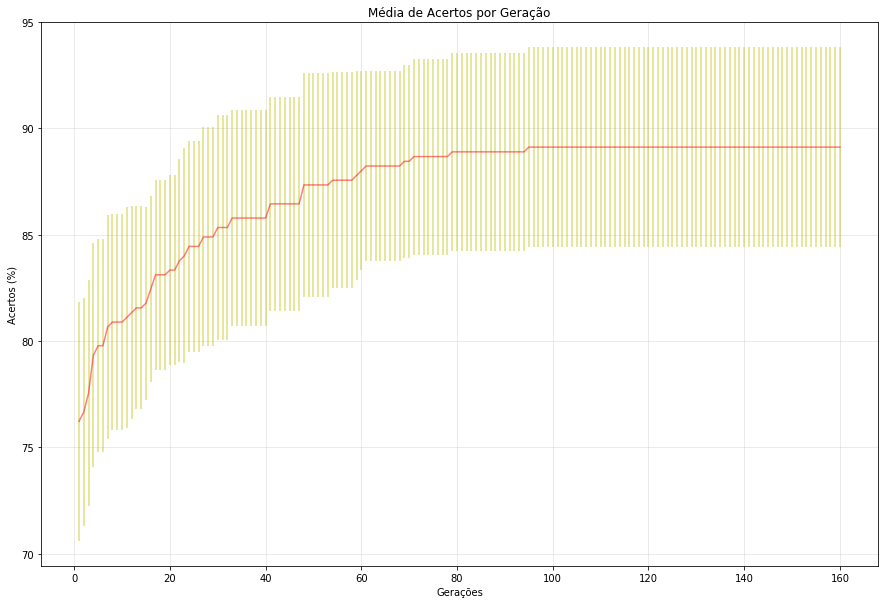

In [7]:
rw11.plot()

#### População: 100 indivíduos | Palavra alvo: 15 genes

In [8]:
rw12.run(verbose=True)

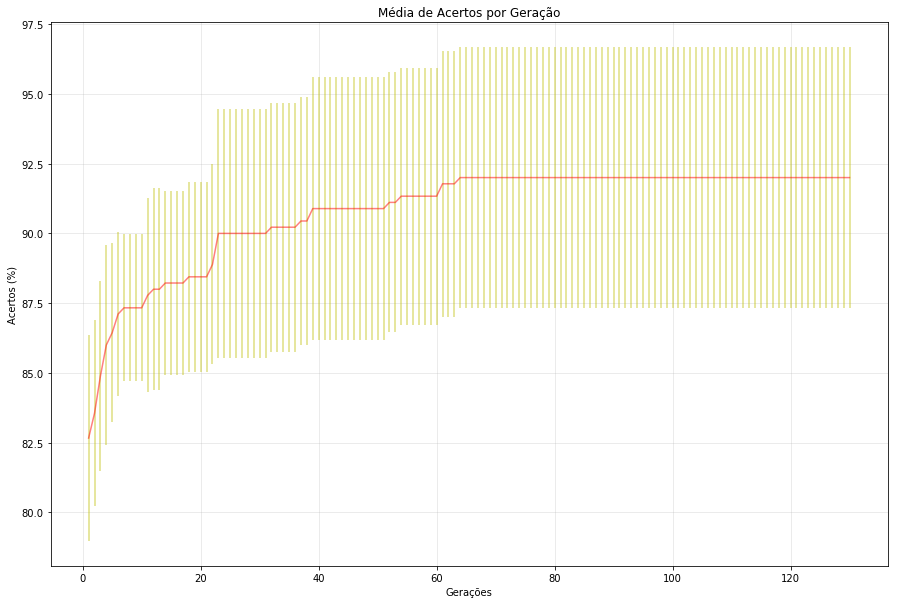

In [9]:
rw12.plot()

#### População: 500 indivíduos | Palavra alvo: 15 genes

In [10]:
rw13.run(verbose=True)

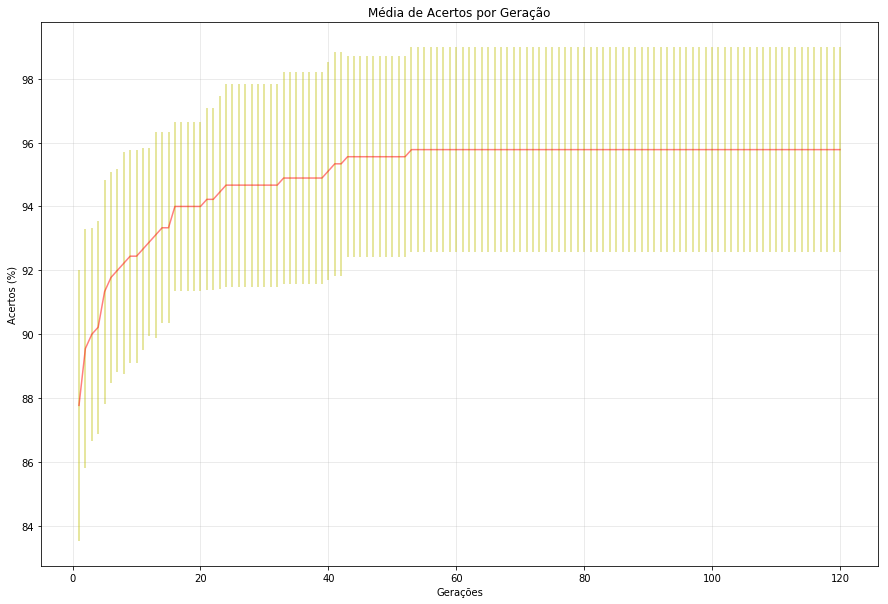

In [11]:
rw13.plot()

#### População: 1000 indivíduos | Palavra alvo: 15 genes

In [12]:
rw14.run(verbose=True)

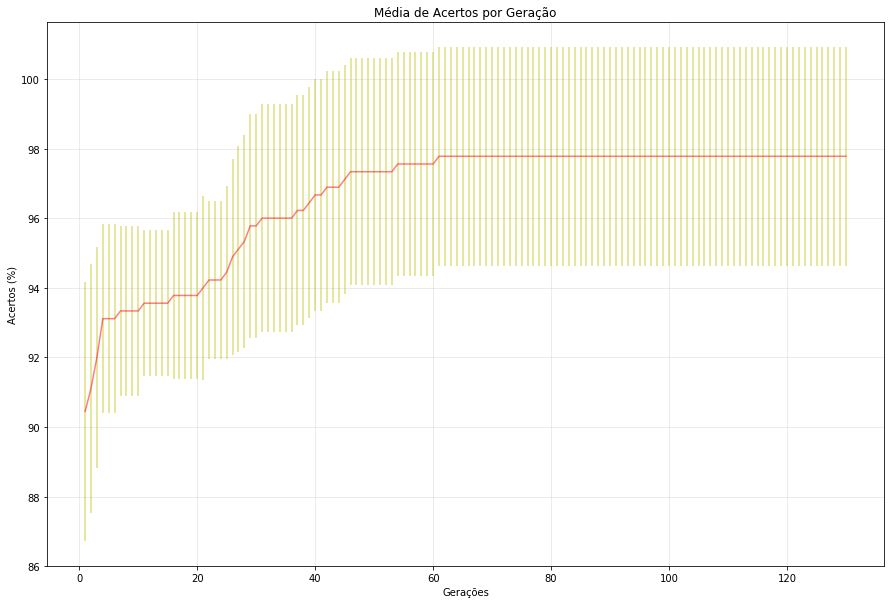

In [13]:
rw14.plot()

---

### 2.2.2. Cenário 2

Para este cenário, a palavra alvo é gerada aleatóriamente pela função `target()`, com um tamanho fixo de 30 bits.

In [14]:
print("Palavra alvo: ", t2)

Palavra alvo:  [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [15]:
rw21 = Randomwalk(alphabet=[0, 1], target=t2, psize=psize1, gcounter=gcount, tcounter=30)
rw22 = Randomwalk(alphabet=[0, 1], target=t2, psize=psize2, gcounter=gcount, tcounter=30)
rw23 = Randomwalk(alphabet=[0, 1], target=t2, psize=psize3, gcounter=gcount, tcounter=30)
rw24 = Randomwalk(alphabet=[0, 1], target=t2, psize=psize4, gcounter=gcount, tcounter=30)

#### População: 20 indivíduos | Palavra alvo: 25 genes

In [16]:
rw21.run(verbose=True)

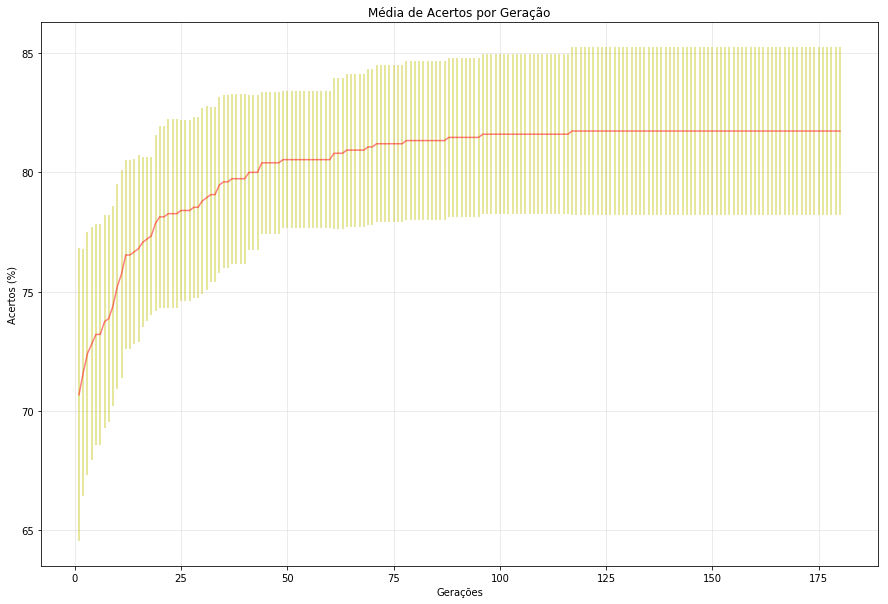

In [17]:
rw21.plot()

#### População: 100 indivíduos | Palavra alvo: 25 genes

In [18]:
rw22.run(verbose=True)

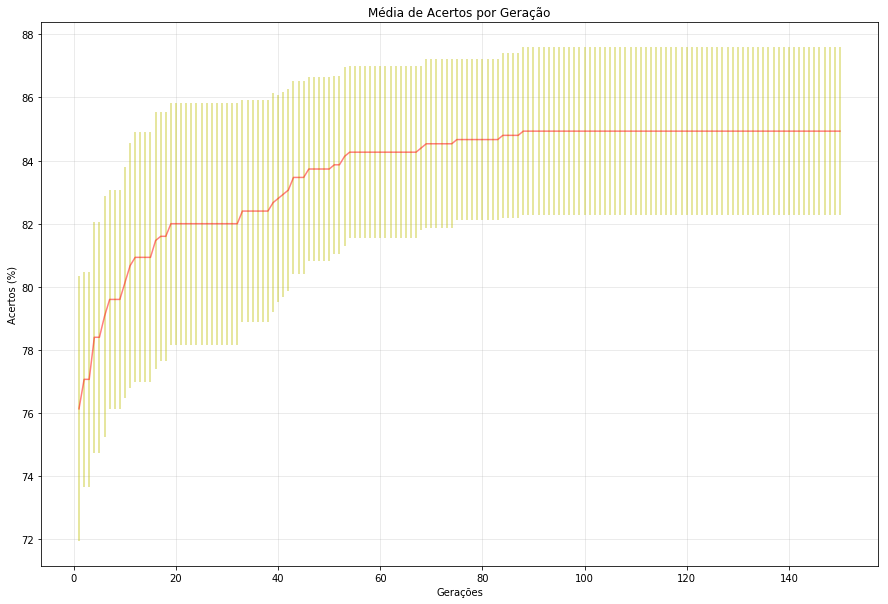

In [19]:
rw22.plot()

#### População: 500 indivíduos | Palavra alvo: 25 genes

In [20]:
rw23.run(verbose=True)

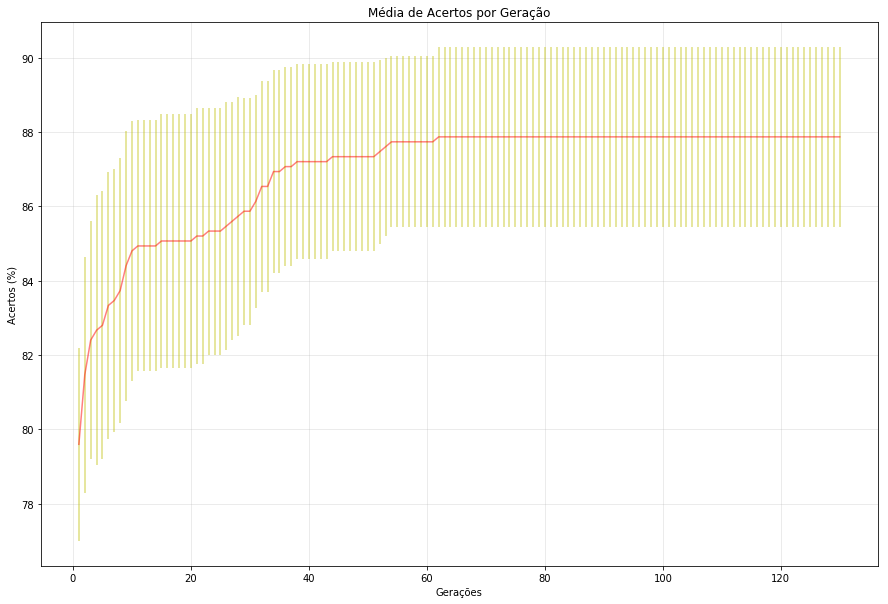

In [21]:
rw23.plot()

#### População: 1000 indivíduos | Palavra alvo: 25 genes

In [22]:
rw24.run(verbose=True)

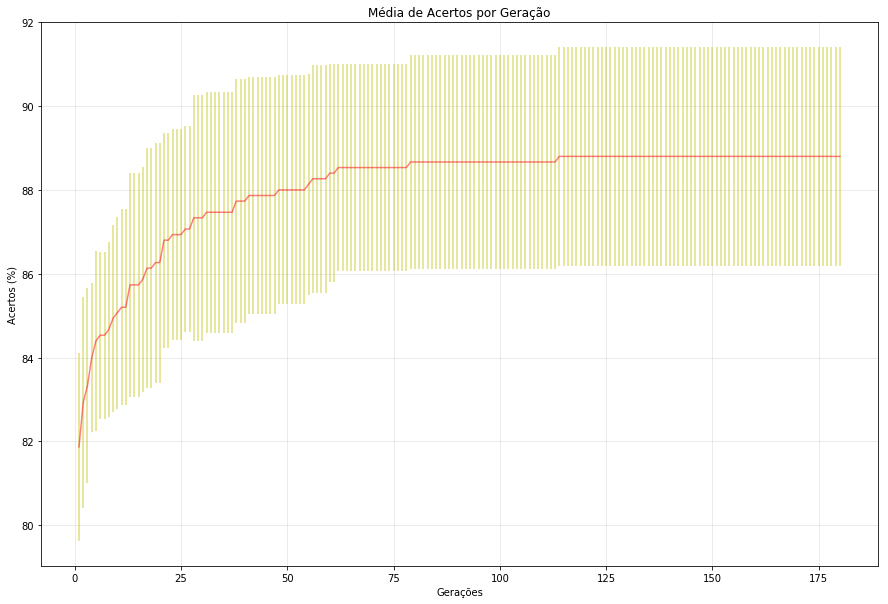

In [23]:
rw24.plot()

---

### 2.2.3. Cenário 3

Para este cenário, a palavra alvo é gerada aleatóriamente pela função `target()`, com um tamanho fixo de 40 bits.

In [24]:
print("Palavra alvo: ", t3)

Palavra alvo:  [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]


In [25]:
rw31 = Randomwalk(alphabet=[0, 1], target=t3, psize=psize1, gcounter=gcount, tcounter=30)
rw32 = Randomwalk(alphabet=[0, 1], target=t3, psize=psize2, gcounter=gcount, tcounter=30)
rw33 = Randomwalk(alphabet=[0, 1], target=t3, psize=psize3, gcounter=gcount, tcounter=30)
rw34 = Randomwalk(alphabet=[0, 1], target=t3, psize=psize4, gcounter=gcount, tcounter=30)

#### População: 20 indivíduos | Palavra alvo: 40 genes

In [26]:
rw31.run(verbose=True)

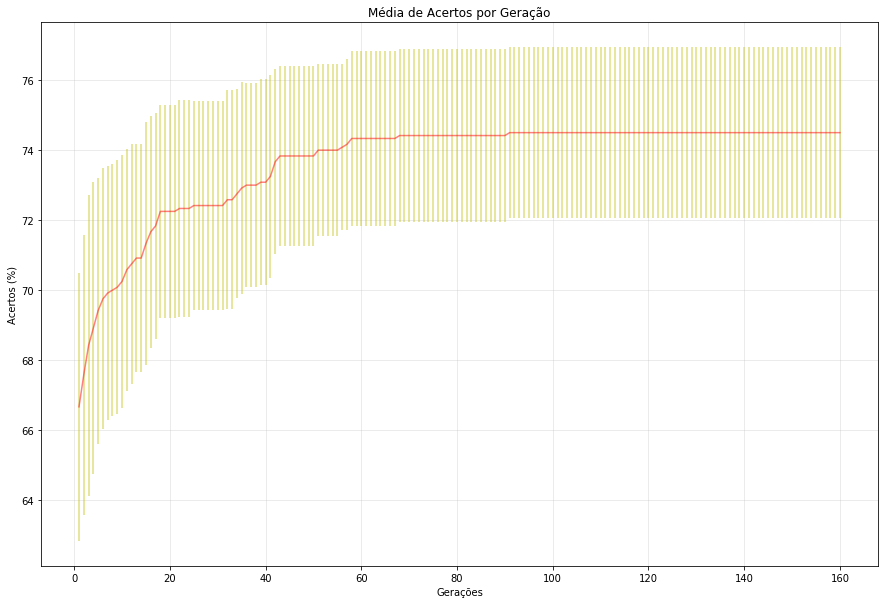

In [27]:
rw31.plot()

#### População: 100 indivíduos | Palavra alvo: 40 genes

In [28]:
rw32.run(verbose=True)

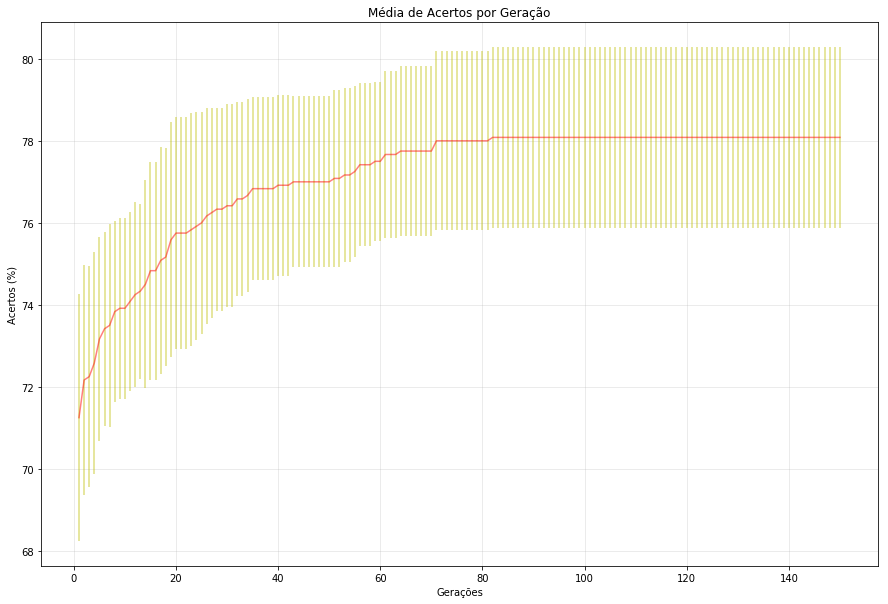

In [29]:
rw32.plot()

#### População: 500 indivíduos | Palavra alvo: 40 genes

In [30]:
rw33.run(verbose=True)

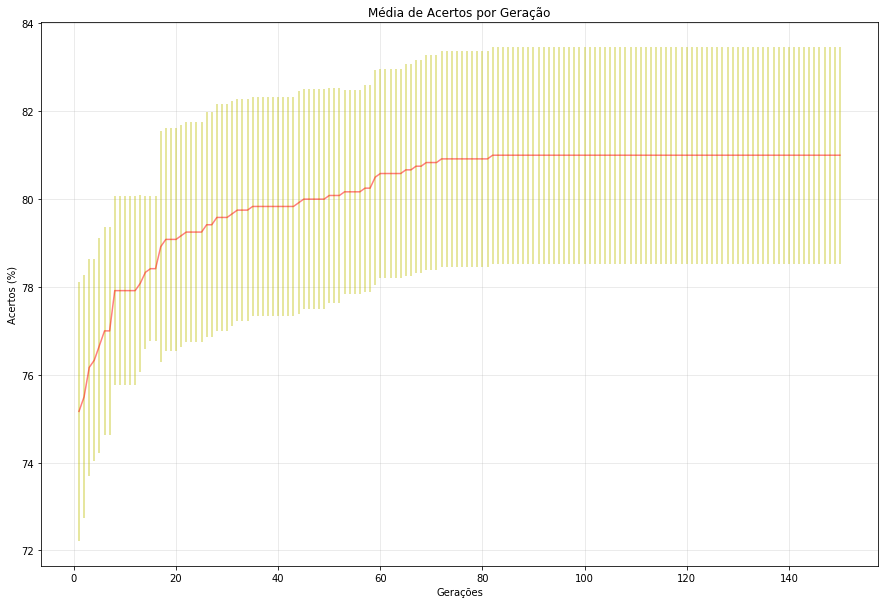

In [31]:
rw33.plot()

#### População: 1000 indivíduos | Palavra alvo: 40 genes

In [32]:
rw34.run(verbose=True)

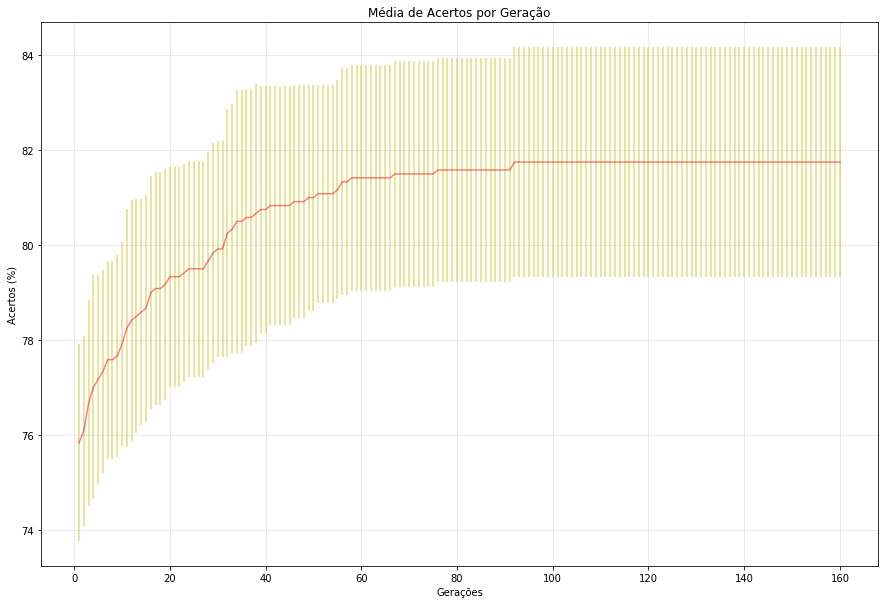

In [33]:
rw34.plot()

---

## 2.3. Resultados

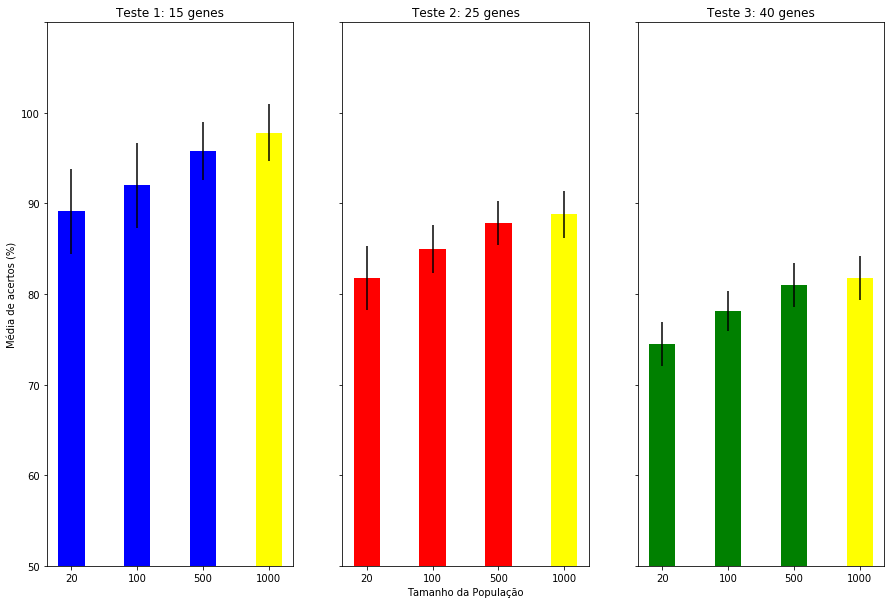

In [68]:
lb = ["20", "100", "500", "1000"]
index  = np.arange(1, 5, 1)

r1 = [ [ r[-1] for r in rw11.best_scores ],
       [ r[-1] for r in rw12.best_scores ],
       [ r[-1] for r in rw13.best_scores ],
       [ r[-1] for r in rw14.best_scores ] ]

r2 = [ [ r[-1] for r in rw21.best_scores ],
       [ r[-1] for r in rw22.best_scores ],
       [ r[-1] for r in rw23.best_scores ],
       [ r[-1] for r in rw24.best_scores ] ]

r3 = [ [ r[-1] for r in rw31.best_scores ],
       [ r[-1] for r in rw32.best_scores ],
       [ r[-1] for r in rw33.best_scores ],
       [ r[-1] for r in rw34.best_scores ] ]

rm1 = np.mean(r1, axis=1)
rstd1 = np.std(r1, axis=1)

rm2 = np.mean(r2, axis=1)
rstd2 = np.std(r2, axis=1)

rm3 = np.mean(r3, axis=1)
rstd3 = np.std(r3, axis=1)

fig = plt.figure(figsize=(15, 10)) 
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
ax3 = plt.subplot(1, 3, 3, sharey=ax1)

c1 = ['blue', 'blue', 'blue', 'yellow']
ax1.bar(index, rm1, yerr=rstd1, width=0.4, color=c1)
ax1.set_xticks(index)
ax1.set_xticklabels(labels=lb)
ax1.set_title(u"Teste 1: 15 genes")
ax1.set_ylabel(u"Média de acertos (%)")
plt.ylim(50, 110, 5)
plt.setp(ax1.get_yticklabels()[-1], visible=False)

c2 = ['red', 'red', 'red', 'yellow']
ax2.bar(index, rm2, yerr=rstd2, width=0.4, color=c2)
ax2.set_xticks(index)
ax2.set_xticklabels(labels=lb)
ax2.set_title(u"Teste 2: 25 genes")
ax2.set_xlabel(u"Tamanho da População")
plt.setp(ax2.get_yticklabels(), visible=False)

c3 = ['green', 'green', 'green', 'yellow']
ax3.bar(index, rm3, yerr=rstd3, width=0.4, color=c3)
ax3.set_xticks(index)
ax3.set_xticklabels(labels=lb)
ax3.set_title(u"Teste 3: 40 genes")
plt.setp(ax3.get_yticklabels(), visible=False)


plt.show()

---

# PARTE 3: Algoritmo Genético

## 3.1. Introdução

---

## 3.2. Seleção de parâmetros

Neste algoritmo, alguns parâmetros precisam ser ajustados, para que se obtenha maior desempenho, ou ainda, maior acurácia na aquisição dos resultados. Estes parâmetros são:
 - taxa de mutação (mrate);
 - taxa de cruzamento (brate);
 - desvio padrão (sigma);
 - tamanho do ringue (rsize).  
 
Para a seleção dos parâmetros utilizados na execução dos nossos testes, foi adotada a seguinte metodologia:
 - Executados no pior dos cenários (palavra de 40 bits, população de 20 indivíduos);
 - Fixando 3 dos 4 parâmetros, foram realizados 4 testes para cada variável;
 - A cada 4 testes, verifica-se qual combinação rendeu o melhor resultado. A variável contida na melhor combinação é passada para os próximos testes.  
 
Estes foram os resultados obtidos:  

| wsize | psize | rsize | mrate | brate | sigma | mean_gen |   hits   |   >95%   |
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:--------:|:--------:|:--------:|
|   40  |   20  |   3   |  0.03 |  0.7  |  0.01 |  96.16   |    17    |    25    |
|   40  |   20  |   3   |  0.03 |  0.7  |  0.05 |  86.2    |    16    |    27    |
|   40  |   20  |   3   |  0.03 |  0.7  |  0.1  |  81.26   |    19    |    29    |
|   40  |   20  |   3   |  0.03 |  0.7  |  0.5  |    97    |    19    |    28    |
|   40  |   20  |   3   |  0.03 |  0.7  |  0.1  |  92.16   |    17    |    30    |
|   40  |   20  |   3   |  0.03 |  0.1  |  0.1  |  165.16  |    2     |    9     |
|   40  |   20  |   3   |  0.03 |  1    |  0.1  |   88.16  |    15    |    29    |
|   40  |   20  |   3   |  0.03 |  0.5  |  0.1  |  112.6   |    14    |    26    |
|   40  |   20  |   3   |  0.03 |  0.7  |  0.1  |  100.03  |    11    |    25    |
|   40  |   20  |   3   |  0.01 |  0.7  |  0.1  |  81.26   |    13    |    29    |
|   40  |   20  |   3   |  0.3  |  0.7  |  0.1  |  99.03   |    0     |    0     |
|   40  |   20  |   3   |  0.1  |  0.7  |  0.1  |  139.63  |    1     |    3     |
|   40  |   20  |   **3**   |  **0.01** |  **0.7**  |  **0.1**  |  75.53   |    17    |    27    |
|   40  |   20  |   5   |  0.01 |  0.7  |  0.1  |  79.66   |    12    |    28    |
|   40  |   20  |   7   |  0.01 |  0.7  |  0.1  |   88.96  |    14    |    29    |
|   40  |   20  |   10  |  0.01 |  0.7  |  0.1  |  105.23  |    16    |    28    |  

Sendo assim, conforme visto nos resultados acima, a melhor combinação de parâmetros é:
 - rsize = 3
 - mrate = 0.01
 - brate = 0.7
 - sigma = 0.1
 
A seguir, os testes para os demais cenários são realizados. 

---

## 3.3. Testes

Para se obter informações de onde possamos tirar conclusões sobre o algoritmo apresentado, se faz necessária a realização de alguns testes, utilizando algumas variáveis como parâmetros. Nesse caso, temos temos 4 variáveis: tamanho da população (`psize`), tamanho da palavra alvo (`wsize`), número de testes (`tcounter`) e o número de gerações (`gcounter`).

Os testes a seguir foram organizado em cenários que destacam apenas uma das quatro variáveis por vez, mantendo as restantes em estado constante. No entanto, para o escopo deste estudo, apenas duas dessas variáveis são alteradas, `psize` e `wsize`. As variáveis se alternam como na tabela abaixo:  

| wsize | psize | rsize | mrate | brate | sigma | gcounter | tcounter |
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:--------:|:--------:|
|   15  |   20  |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |
|   15  |  100  |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |
|   15  |  500  |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |
|   15  |  100  |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |
|   25  |   20  |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |
|   25  |  100  |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |
|   25  |  500  |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |
|   25  |  1000 |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |
|   40  |   20  |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |
|   40  |  100  |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |
|   40  |  500  |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |
|   40  |  1000 |   3   |  0.01 |  0.7  |  0.1 |    60    |    30    |


As quatro primeiras linhas da tabela são referentes aos cenários utilizados para o primeiro teste. As quatro linhas seguintes foram utilizadas para o segunto teste. As outras quatro linhas são usadas para o último teste.

In [34]:
t1 = [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]
t2 = [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
      0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
t3 = [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
      0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
      0, 0, 1, 1, 0, 0, 0, 1, 1, 0]

psize1  =   20
psize2  =  100
psize3  =  500
psize4  = 1000
psize5  = 5000

gcount = 60

### 3.3.1. Cenário 1

Para este cenário, a palavra alvo é gerada aleatóriamente pela função `target()`, com um tamanho fixo de 20 bits.

In [35]:
print("Palavra alvo: ", t1)

Palavra alvo:  [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]


In [36]:
ag11 = GeneticAlgorithm(alphabet=[0, 1], target=t1, psize=psize1, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)
ag12 = GeneticAlgorithm(alphabet=[0, 1], target=t1, psize=psize2, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)
ag13 = GeneticAlgorithm(alphabet=[0, 1], target=t1, psize=psize3, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)
ag14 = GeneticAlgorithm(alphabet=[0, 1], target=t1, psize=psize4, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)

#### População: 20 indivíduos | Palavra alvo: 15 genes

In [37]:
ag11.run(verbose=True)

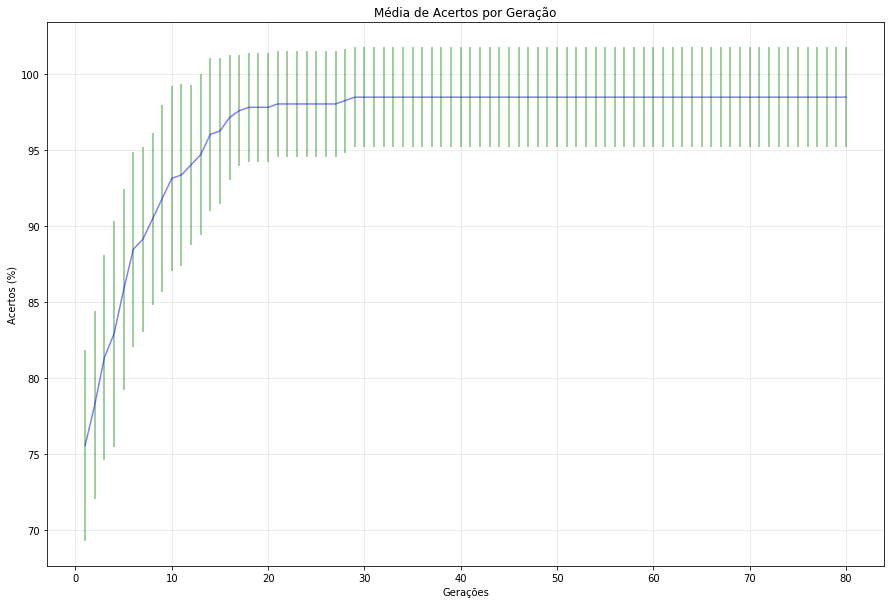

In [38]:
ag11.plot()

#### População: 100 indivíduos | Palavra alvo: 15 genes

In [39]:
ag12.run(verbose=True)

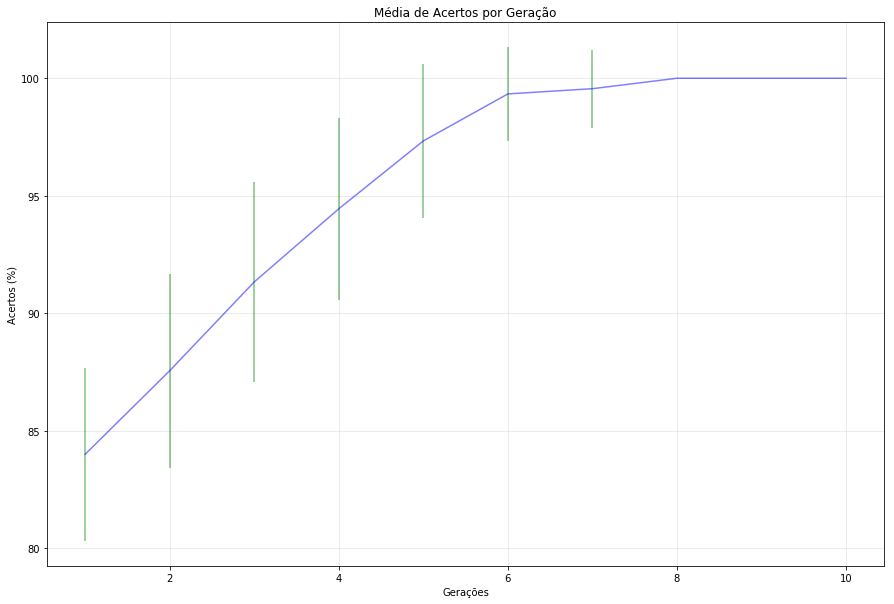

In [40]:
ag12.plot()

#### População: 500 indivíduos | Palavra alvo: 15 genes

In [41]:
ag13.run(verbose=True)

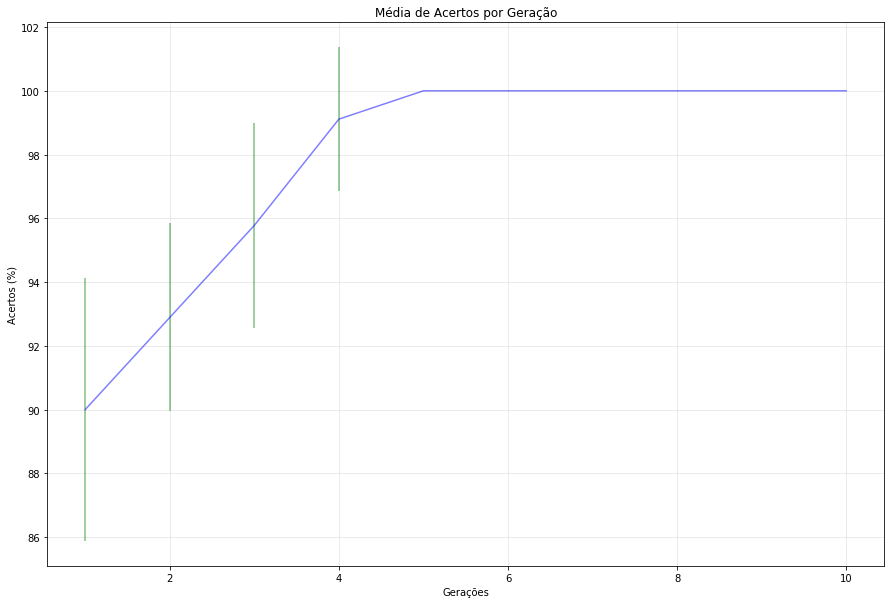

In [42]:
ag13.plot()

#### População: 1000 indivíduos | Palavra alvo: 15 genes

In [43]:
ag14.run(verbose=True)

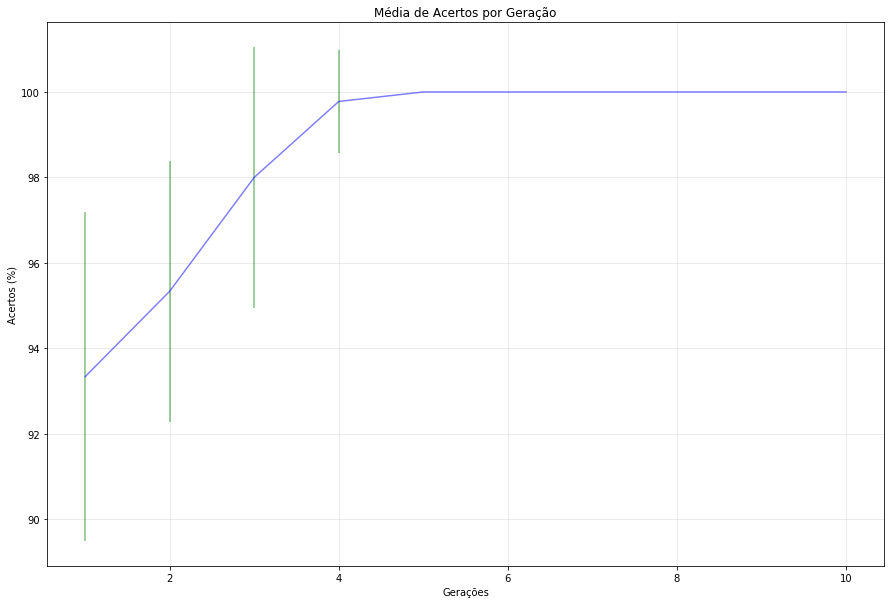

In [44]:
ag14.plot()

---

### 3.3.2. Cenário 2

Para este cenário, a palavra alvo é gerada aleatóriamente pela função `target()`, com um tamanho fixo de 30 bits.

In [45]:
print("Palavra alvo: ", t2)

Palavra alvo:  [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [46]:
ag21 = GeneticAlgorithm(alphabet=[0, 1], target=t2, psize=psize1, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)
ag22 = GeneticAlgorithm(alphabet=[0, 1], target=t2, psize=psize2, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)
ag23 = GeneticAlgorithm(alphabet=[0, 1], target=t2, psize=psize3, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)
ag24 = GeneticAlgorithm(alphabet=[0, 1], target=t2, psize=psize4, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)

#### População: 20 indivíduos | Palavra alvo: 25 genes

In [47]:
ag21.run(verbose=True)

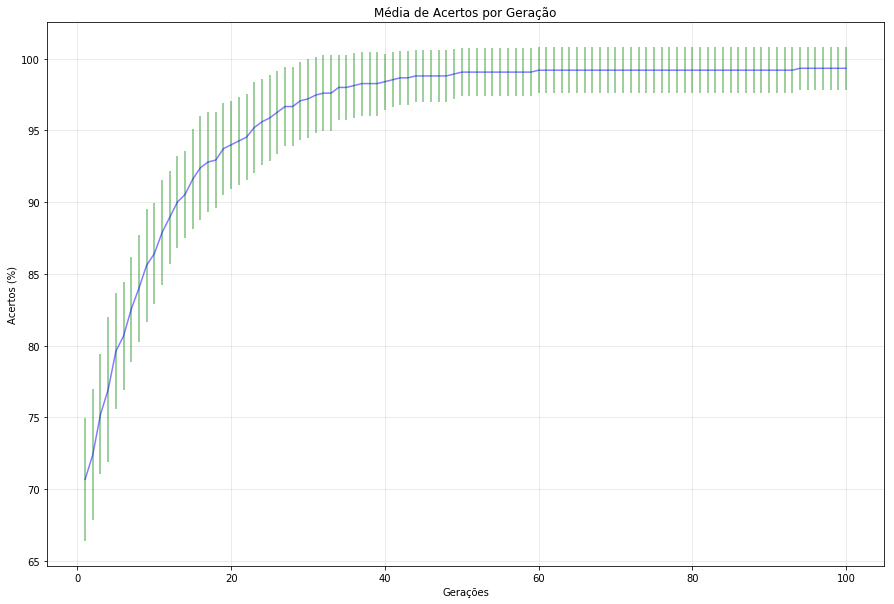

In [48]:
ag21.plot()

#### População: 100 indivíduos | Palavra alvo: 25 genes

In [49]:
ag22.run(verbose=True)

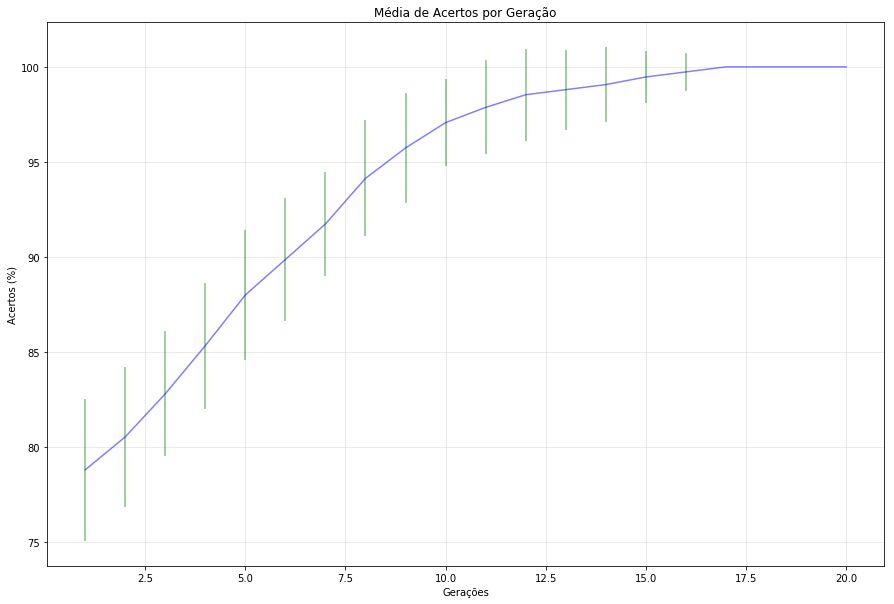

In [50]:
ag22.plot()

#### População: 500 indivíduos | Palavra alvo: 25 genes

In [51]:
ag23.run(verbose=True)

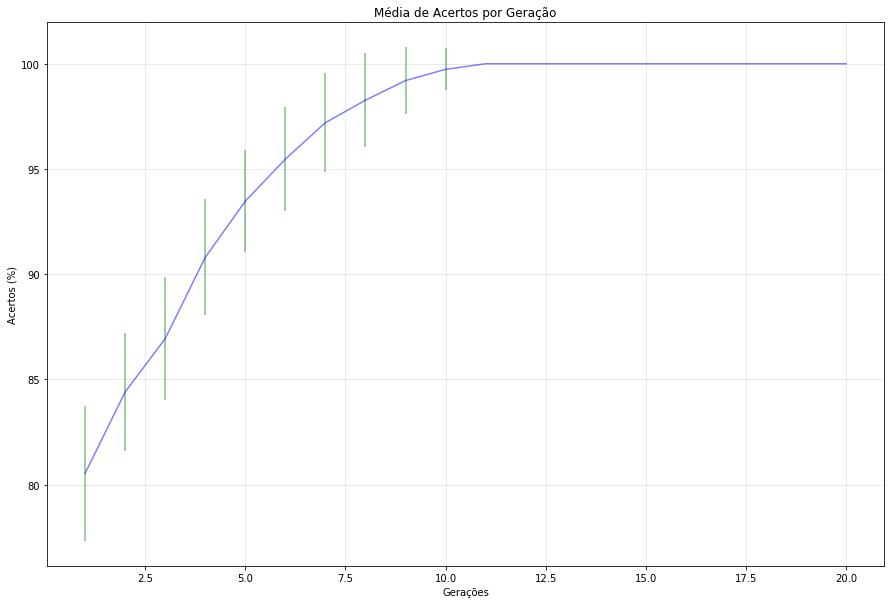

In [52]:
ag23.plot()

#### População: 1000 indivíduos | Palavra alvo: 25 genes

In [53]:
ag24.run(verbose=True)

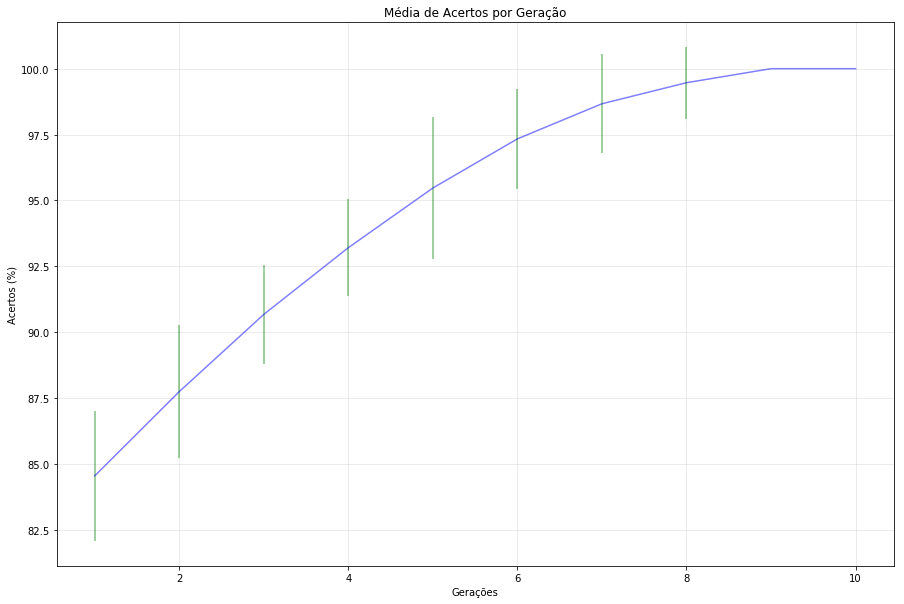

In [54]:
ag24.plot()

---

### 3.3.3. Cenário 3

Para este cenário, a palavra alvo é gerada aleatóriamente pela função `target()`, com um tamanho fixo de 40 bits.

In [55]:
print("Palavra alvo: ", t3)

Palavra alvo:  [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]


In [56]:
ag31 = GeneticAlgorithm(alphabet=[0, 1], target=t3, psize=psize1, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)
ag32 = GeneticAlgorithm(alphabet=[0, 1], target=t3, psize=psize2, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)
ag33 = GeneticAlgorithm(alphabet=[0, 1], target=t3, psize=psize3, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)
ag34 = GeneticAlgorithm(alphabet=[0, 1], target=t3, psize=psize4, rsize=3, mrate=0.01, brate=0.7, sigma=0.1, gcounter=gcount, tcounter=30)

#### População: 20 indivíduos | Palavra alvo: 40 genes

In [57]:
ag31.run(verbose=True)

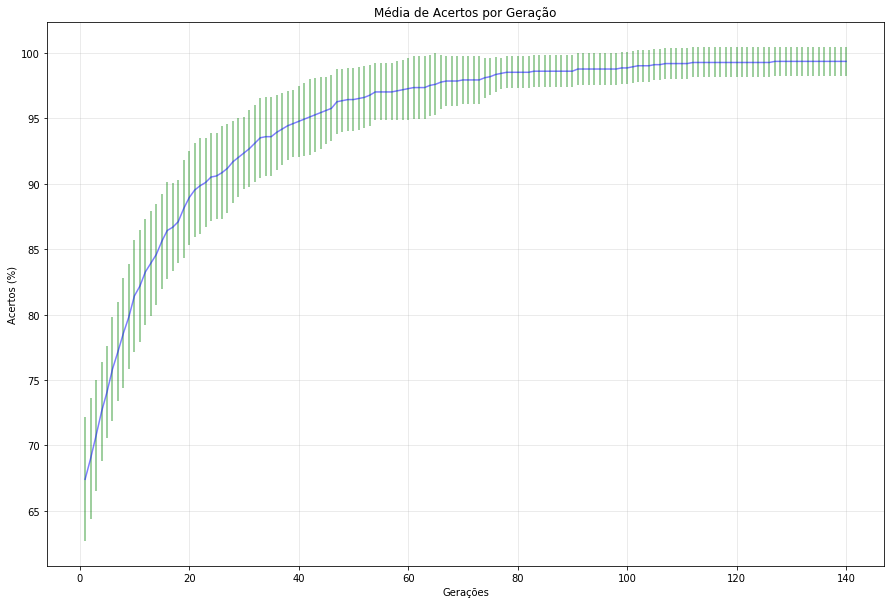

In [58]:
ag31.plot()

#### População: 100 indivíduos | Palavra alvo: 40 genes

In [59]:
ag32.run(verbose=True)

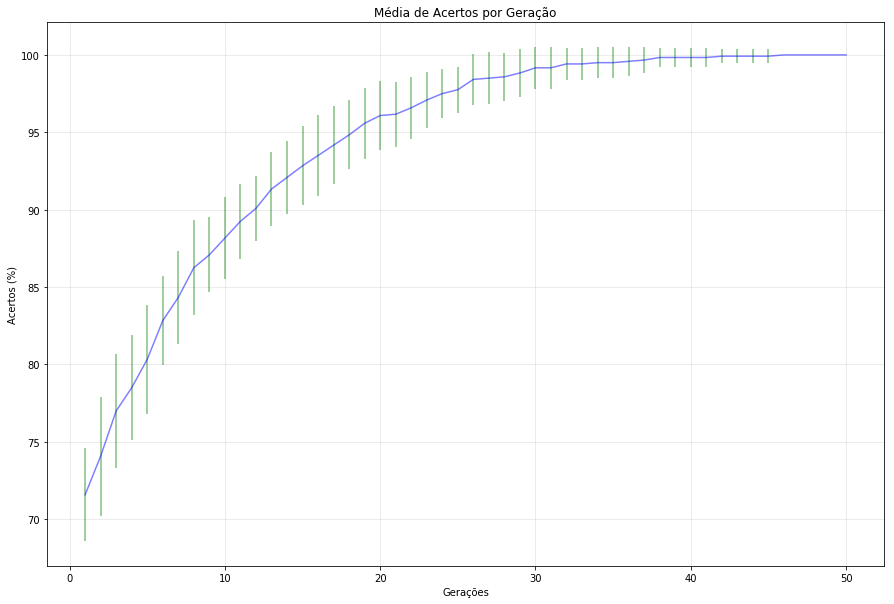

In [60]:
ag32.plot()

#### População: 500 indivíduos | Palavra alvo: 40 genes

In [61]:
ag33.run(verbose=True)

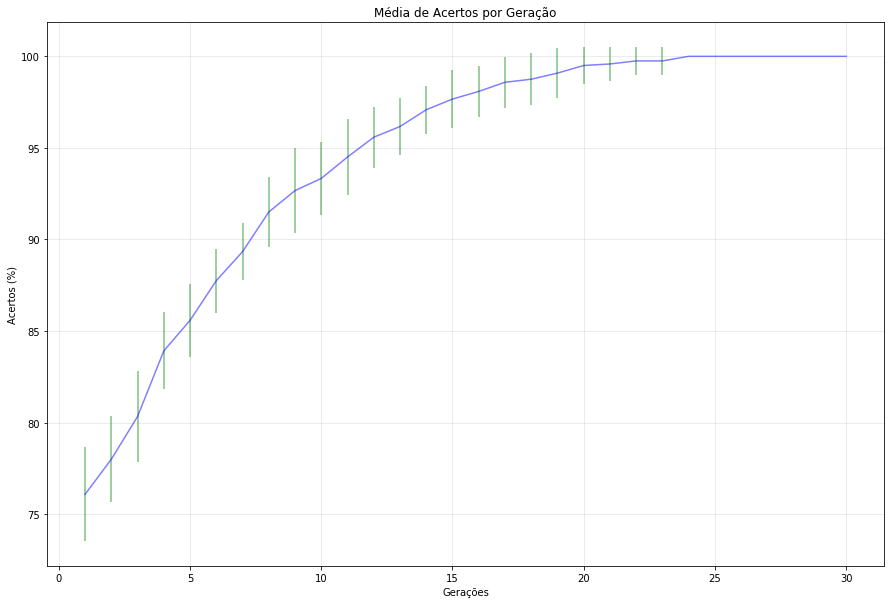

In [62]:
ag33.plot()

#### População: 1000 indivíduos | Palavra alvo: 40 genes

In [63]:
ag34.run(verbose=True)

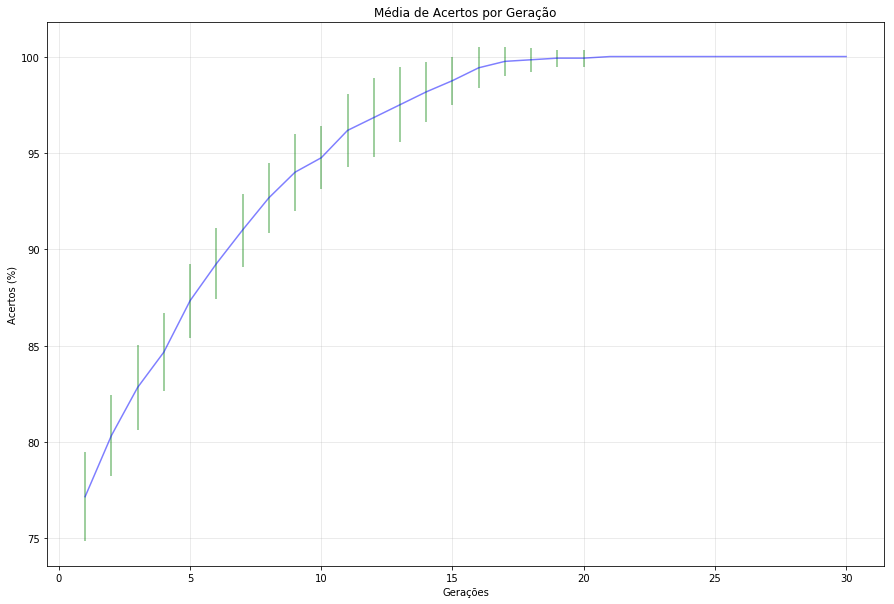

In [64]:
ag34.plot()

---

## 3.4. Resultados

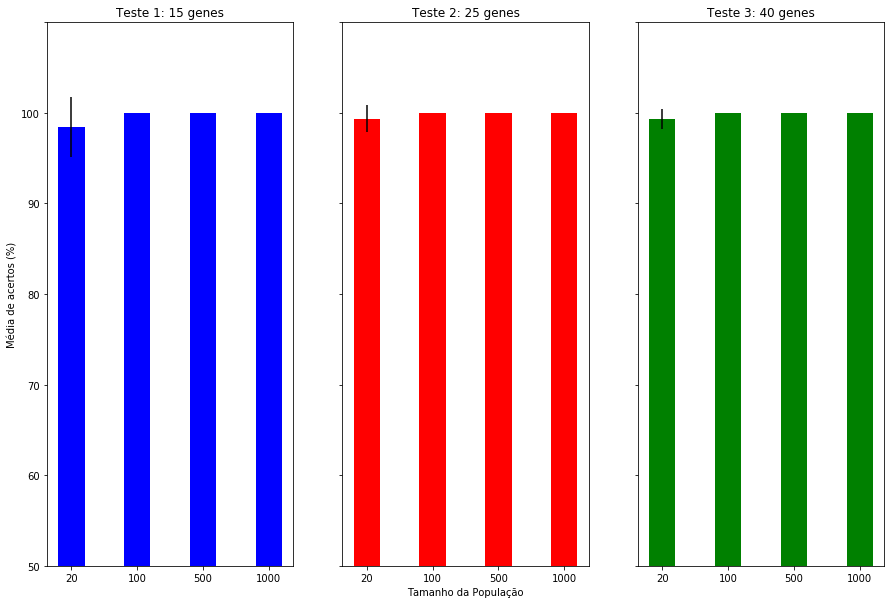

In [70]:
lb = ["20", "100", "500", "1000"]
index  = np.arange(1, 5, 1)

a1 = [ [ a[-1] for a in ag11.best_scores ],
       [ a[-1] for a in ag12.best_scores ],
       [ a[-1] for a in ag13.best_scores ],
       [ a[-1] for a in ag14.best_scores ] ]

a2 = [ [ a[-1] for a in ag21.best_scores ],
       [ a[-1] for a in ag22.best_scores ],
       [ a[-1] for a in ag23.best_scores ],
       [ a[-1] for a in ag24.best_scores ] ]

a3 = [ [ a[-1] for a in ag31.best_scores ],
       [ a[-1] for a in ag32.best_scores ],
       [ a[-1] for a in ag33.best_scores ],
       [ a[-1] for a in ag34.best_scores ] ]

am1 = np.mean(a1, axis=1)
astd1 = np.std(a1, axis=1)

am2 = np.mean(a2, axis=1)
astd2 = np.std(a2, axis=1)

am3 = np.mean(a3, axis=1)
astd3 = np.std(a3, axis=1)

fig = plt.figure(figsize=(15, 10)) 
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
ax3 = plt.subplot(1, 3, 3, sharey=ax1)

c1 = ['blue', 'blue', 'blue', 'blue']
ax1.bar(index, am1, yerr=astd1, width=0.4, color=c1)
ax1.set_xticks(index)
ax1.set_xticklabels(labels=lb)
ax1.set_title(u"Teste 1: 15 genes")
ax1.set_ylabel(u"Média de acertos (%)")
plt.ylim(50, 110, 5)
plt.setp(ax1.get_yticklabels()[-1], visible=False)

c2 = ['red', 'red', 'red', 'red']
ax2.bar(index, am2, yerr=astd2, width=0.4, color=c2)
ax2.set_xticks(index)
ax2.set_xticklabels(labels=lb)
ax2.set_title(u"Teste 2: 25 genes")
ax2.set_xlabel(u"Tamanho da População")
plt.setp(ax2.get_yticklabels(), visible=False)

c3 = ['green', 'green', 'green', 'green']
ax3.bar(index, am3, yerr=astd3, width=0.4, color=c3)
ax3.set_xticks(index)
ax3.set_xticklabels(labels=lb)
ax3.set_title(u"Teste 3: 40 genes")
plt.setp(ax3.get_yticklabels(), visible=False)


plt.show()

---

# PARTE 4: Avaliação de resultados

## 4.3. Baseline

Como _baseline_, foram selecionados os testes cujos resultados encontraram, ou que tenham se aproximado mais da palavra alvo. Para tanto, não bastou que o resultado fosse alcançado um certo número de vezes. Todas as _baselines_ selecionadas também levam em consideração a precisão desses resultados. Então, os melhores resultados foram aqueles em que o algoritmo convergiu, ou seja, deixou de variar a sua acurácia; e que se aproximou do resultado, ou o tenha encontrado.  

Os gráficos abaixo exibem esses resultados, um para cada cenário:

#### População: 1000 indivíduos | Palavra alvo: 15 genes

#### População: 100 indivíduos | Palavra alvo: 25 genes

#### População: 1000 indivíduos | Palavra alvo: 40 genes

---

## 4.4. Hipóteses  

Com base nos experimentos realizados anteriormente, podemos levantar hipóteses a respeito da eficácia do método heurístico aplicado:

1. Por se tratar de um método de caráter puramente randômico, não é possível afirmar que a solução para o problema será encontrada, independente do número de gerações empregadas, ou da quantidade de indivíduos contidos na população;
2. Não há parâmetro que consiga aproximar mais os resultados obtidos dos esperados;
3. A ausência de operadores que permitam que as informações do melhor indivíduo sejam passadas para outros indivíduos da população, faz com que não haja possibilidade de melhora nos resultados.

---

## 4.5. Resultados  


Partindo dos resultados obtidos, fazemos considerações a respeito das hipóteses geradas anteriormente.

O gráfico abaixo mostra o comparativo dos melhores resultados obtidos em cada cenário; e foi obtido plotando as médias dos melhores resultados de cada teste.



---

## 4.6. Considerações Finais

Este trabalho possibilitou o maior entendimento a cerca da empregabilidade de métodos heurísticos na solução de problemas, dando margem à análise crítica a respeito de como esta classe de algoritmos podem ser utilizados, e como os parâmetros configurados podem, ou não, influenciar nos resultados obtidos.